In [8]:
%reload_ext autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
%matplotlib inline
from astroML.plotting          import hist
from astropy.io                import fits
from astropy.modeling          import models, fitting
from datetime                  import datetime
from image_registration        import cross_correlation_shifts
from glob                      import glob
from functools                 import partial
from matplotlib.ticker         import MaxNLocator
from matplotlib                import style
from os                        import listdir
from least_asymmetry.asym      import actr, moments, fitgaussian
from multiprocessing           import cpu_count, Pool
from numpy                     import min as npmin, max as npmax, zeros, arange, sum, float, isnan, hstack
from numpy                     import int32 as npint, round as npround, nansum as sum, nanstd as std
from os                        import environ, path, mkdir
from pandas                    import DataFrame, read_csv, read_pickle, scatter_matrix
from photutils                 import CircularAperture, CircularAnnulus, aperture_photometry, findstars
from pylab                     import ion, gcf, sort, linspace, indices, median, mean, std, empty, figure, transpose, ceil
from pylab                     import concatenate, pi, sqrt, ones, diag, inf, rcParams, isnan, isfinite, array, nanmax
from pylab                     import figure, plot, imshow, scatter, legend
from seaborn                   import *
from scipy.special             import erf
from scipy                     import stats
from sklearn.cluster           import DBSCAN
from sklearn.externals         import joblib
from sklearn.preprocessing     import StandardScaler
from socket                    import gethostname
from statsmodels.robust        import scale
from statsmodels.nonparametric import kde
from sys                       import exit
from time                      import time, localtime
from tqdm                      import tqdm_notebook

from numpy                     import zeros, nanmedian as median, nanmean as mean, nan
from sys                       import exit
from sklearn.externals         import joblib

import numpy as np

In [10]:
startFull = time()

**Master Class for Exoplanet Time Series Observation Photometry**

In [11]:
from ExoplanetTSO_Auxiliary import wanderer

In [12]:
def clipOutlier2D(arr2D, nSig=10):
    arr2D     = arr2D.copy()
    medArr2D  = median(arr2D,axis=0)
    sclArr2D  = np.sqrt(((scale.mad(arr2D)**2.).sum()))
    outliers  = abs(arr2D - medArr2D) >  nSig*sclArr2D
    inliers   = abs(arr2D - medArr2D) <= nSig*sclArr2D
    arr2D[outliers] = median(arr2D[inliers],axis=0)
    return arr2D

In [13]:
rcParams['figure.dpi'] = 150
rcParams['image.interpolation'] = 'None'
rcParams['image.cmap']          = 'Blues_r'
rcParams['axes.grid']           = False

As an example, Spitzer data is expected to be store in the directory structure:

`$HOME/PLANET_DIRECTORY/PLANETNAME/data/raw/AORDIR/CHANNEL/bcd/`

EXAMPLE:

1. On a Linux machine
2. With user `tempuser`,
3. And all Spitzer data is store in `Research/Planets`
4. The planet named `Happy-5b`
5. Observed during AOR r11235813
6. In CH2 (4.5 microns)

The `loadfitsdir` should read as: `/home/tempuser/Research/Planets/HAPPY5/data/raw/r11235813/ch2/bcd/`

In [21]:
from os import environ

planetName      = 'planetName'
planetDirectory = '/Research/Planets/PhaseCurves/'

channel = 'ch2/'
# channel = 'ch2/'

dataSub = 'bcd/'

dataDir     = environ['HOME'] + planetDirectory + planetName + '/data/raw/' + channel + '/big/'

AORs = []
for dirNow in glob(dataDir + '/*'):
    AORs.append(dirNow.split('/')[-1])

fileExt = '*bcd.fits'
uncsExt = '*bunc.fits'

In [22]:
len(AORs)

2

In [ ]:
iAOR        = 0
AORNow      = AORs[iAOR]
loadfitsdir = dataDir + AORNow + '/' + channel + dataSub
print(loadfitsdir)

In [24]:
nCores = cpu_count()

In [25]:
fitsFilenames = glob(loadfitsdir + fileExt)
uncsFilenames = glob(loadfitsdir + uncsExt)

In [ ]:
header_test = fits.getheader(fitsFilenames[0])
print('AORLABEL:\t{}\nNum Fits Files:\t{}\nNum Unc Files:\t{}'.format\
          (header_test['AORLABEL'], len(fitsFilenames), len(uncsFilenames)))

In [ ]:
fitsFilenames

In [ ]:
uncsFilenames

# Load ExoplanetTSO Class

Necessary Constants Spitzer
---

In [29]:
ppm             = 1e6
y,x             = 0,1

yguess, xguess  = 15., 15.   # Specific to Spitzer circa 2010 and beyond
filetype        = 'bcd.fits' # Specific to Spitzer Basic Calibrated Data

Load Stored Instance from Save Files
---

If this is **not** your time, then you can load a saved file in the `loadfitsdir` directory that has the filename:

`PLANETNAME_Wanderer_METHOD_DATE.pickle.save` 

```python
method = 'mean'
example_wanderer_mean = wanderer(loadfitsdir=loadfitsdir, filetype=filetype, 
                                            yguess=yguess, xguess=xguess, method=method)

example_wanderer_mean.load_data_from_save_files(savefiledir='./SaveFiles/', 
                        saveFileNameHeader=planetName+'_Wanderer_Mean_', saveFileType='.pickle.save')
```

```python
method = 'median'
example_wanderer_median = wanderer(loadfitsdir=loadfitsdir_ModA, filetype=filetype, 
                                            yguess=yguess, xguess=xguess, method=method)

example_wanderer_median.load_data_from_save_files(savefiledir='./SaveFiles/', saveFileNameHeader='Example_Wanderer_Median_', saveFileType='.pickle.save')
```

Start a New Instance with Median for the Metric
---

In [30]:
method = 'median'

print('Initialize an instance of `wanderer` as `example_wanderer_median`\n')
example_wanderer_median = wanderer(fitsFileDir=loadfitsdir, filetype=filetype, telescope='Spitzer', 
                                            yguess=yguess, xguess=xguess, method=method, nCores=nCores)

example_wanderer_median.AOR        = AORNow
example_wanderer_median.planetName = planetName
example_wanderer_median.channel    = channel

Initialize an instance of `wanderer` as `example_wanderer_median`



** Not all who wander are lost **


Completed Class Definition at 2018-1-8 23h22m47s


In [ ]:
print('Load Data From Fits Files in ' + loadfitsdir + '\n')
# exarymple_wanderer_median.load_data_from_fits_files()
example_wanderer_median.spitzer_load_fits_file(outputUnits='electrons')#(outputUnits='muJ_per_Pixel')

In [ ]:
print('Skipping Load Data From Save Files in ' + loadfitsdir + '\n')
# example_wanderer_median.load_data_from_save_files(savefiledir='./SaveFiles/', \
# saveFileNameHeader='Example_Wanderer_Median_', saveFileType='.pickle.save')

**Double check for NaNs**

In [33]:
example_wanderer_median.imageCube[np.where(isnan(example_wanderer_median.imageCube))] = \
                                                    np.nanmedian(example_wanderer_median.imageCube)

**Identifier Strong Outliers**

In [34]:
print('Find, flag, and NaN the "Bad Pixels" Outliers' + '\n')
example_wanderer_median.find_bad_pixels()

Find, flag, and NaN the "Bad Pixels" Outliers

There are 28993 'Hot' Pixels


In [35]:
print('Fit for All Centers: Flux Weighted, Gaussian Fitting, Gaussian Moments, Least Asymmetry' + '\n')
# example_wanderer_median.fit_gaussian_centering()
example_wanderer_median.fit_flux_weighted_centering()
# example_wanderer_median.fit_least_asymmetry_centering()
# example_wanderer_median.fit_all_centering() # calling this calls least_asymmetry, which does not work :(

Fit for All Centers: Flux Weighted, Gaussian Fitting, Gaussian Moments, Least Asymmetry

(28864, 32, 32)


HBox(children=(IntProgress(value=0, description='FWC', max=28864), HTML(value='')))

In [121]:
# start = time()
# example_wanderer_median.mp_fit_gaussian_centering(subArray=6)
# print('Operation took {} seconds with {} cores'.format(time()-start, example_wanderer_median.nCores))

# centering_df_copy = example_wanderer_median.centering_df
# example_wanderer_median.centering_df = {}

start = time()
example_wanderer_median.mp_lmfit_gaussian_centering(subArraySize=6, recheckMethod=None, median_crop=False)
print('Operation took {} seconds with {} cores'.format(time()-start, example_wanderer_median.nCores))

Finished with Fitting Centers. Now assigning to instance values.
Operation took 91.81974458694458 seconds with 8 cores


In [122]:
nSig       = 6.1
medY       = median(example_wanderer_median.centering_GaussianFit.T[y])
medX       = median(example_wanderer_median.centering_GaussianFit.T[x])
stdY       = std(example_wanderer_median.centering_GaussianFit.T[y])
stdX       = std(example_wanderer_median.centering_GaussianFit.T[x])

outliers   = (((example_wanderer_median.centering_GaussianFit.T[y] - medY)/stdY)**2 + \
              ((example_wanderer_median.centering_GaussianFit.T[x] - medX)/stdX)**2) > nSig

In [129]:
median(cx), median(cy)

(14.230282327475026, 14.995562415635256)

(14.75, 15.25)

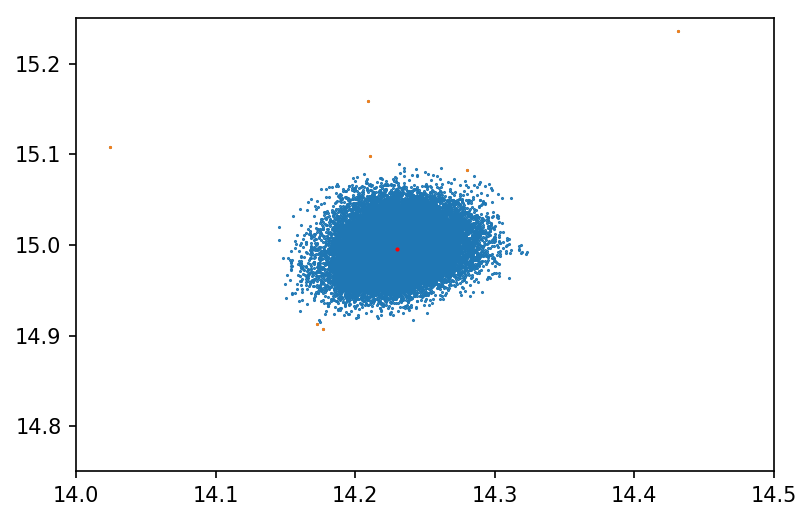

In [134]:
ax = figure().add_subplot(111)
cx, cy = example_wanderer_median.centering_GaussianFit.T[x],example_wanderer_median.centering_GaussianFit.T[y]
ax.plot(cx,cy,'.',ms=1)
ax.plot(cx[outliers],cy[outliers],'.',ms=1)
# ax.plot(median(cx), median(cy),'ro',ms=1)
ax.set_xlim(14,14.5)
ax.set_ylim(14.75,15.25)

In [ ]:
from sklearn.cluster import DBSCAN

dbs     = DBSCAN(n_jobs=-1, eps=0.2, leaf_size=10)
dbsPred = dbs.fit_predict(example_wanderer_median.centering_GaussianFit)

In [ ]:
dbs_options = [k for k in range(-1,100) if (dbsPred==k).sum()]

In [ ]:
dbs_options

In [ ]:
fig = figure(figsize=(6,6))
ax  = fig.add_subplot(111)

medGaussCenters   = median(example_wanderer_median.centering_GaussianFit,axis=0)
sclGaussCenters   = scale.mad(example_wanderer_median.centering_GaussianFit)
sclGaussCenterAvg = np.sqrt(((sclGaussCenters**2.).sum()))

yctrs = example_wanderer_median.centering_GaussianFit.T[y]
xctrs = example_wanderer_median.centering_GaussianFit.T[x]

nSigmas         = 5
for nSig in linspace(1,10,10):
    CircularAperture(medGaussCenters[::-1],nSig*sclGaussCenterAvg).plot(ax=ax)
    for dbsOpt in dbs_options:
        ax.plot(xctrs[dbsPred==dbsOpt], yctrs[dbsPred==dbsOpt],'.',zorder=0)

In [ ]:
npix = 3

stillOutliers = np.where(abs(example_wanderer_median.centering_GaussianFit - medGaussCenters) > 4*sclGaussCenterAvg)[0]
print(len(stillOutliers))
# for o in stillOutliers:
#     figure()
#     imshow(example_wanderer_median.imageCube[o][16-npix:16+npix+1,16-npix:16+npix+1])

In [ ]:
dbsClean  = 0
dbsKeep   = (dbsPred == dbsClean)

**TEST**

Try column-wise background subtraction (and row-wise) to model the read pattern

In [ ]:
nCores = example_wanderer_median.nCores
start = time()
example_wanderer_median.mp_measure_background_circle_masked()
print('CircleBG took {} seconds with {} cores'.format(time() - start, nCores))
start = time()
example_wanderer_median.mp_measure_background_annular_mask()
print('AnnularBG took {} seconds with {} cores'.format(time() - start, nCores))
start = time()
example_wanderer_median.mp_measure_background_KDE_Mode()
print('KDEUnivBG took {} seconds with {} cores'.format(time() - start, nCores))
start = time()
example_wanderer_median.mp_measure_background_median_masked()
print('MedianBG took {} seconds with {} cores'.format(time() - start, nCores))

In [ ]:
((example_wanderer_median.timeCube.min()-.01+0.02) - example_wanderer_median.timeCube.min())*24*60

In [ ]:
fig = figure(figsize=(20,10))
ax  = fig.add_subplot(111)
ax.plot(example_wanderer_median.timeCube, example_wanderer_median.background_CircleMask,'.',alpha=0.2)
ax.plot(example_wanderer_median.timeCube, example_wanderer_median.background_Annulus,'.',alpha=0.2)
ax.plot(example_wanderer_median.timeCube, example_wanderer_median.background_MedianMask,'.',alpha=0.2)
ax.plot(example_wanderer_median.timeCube, example_wanderer_median.background_KDEUniv,'.',alpha=0.2)
ax.axvline(example_wanderer_median.timeCube.min()-.01+0.02)
ax.set_ylim(-25,100)
# ax.set_xlim(example_wanderer_median.timeCube.min()-.01,example_wanderer_median.timeCube.min() + .05)

In [ ]:
example_wanderer_median.measure_effective_width()

In [ ]:
vrad_dist = example_wanderer_median.quadrature_widths - np.median(example_wanderer_median.quadrature_widths)
vrad_dist = clipOutlier2D(vrad_dist, nSig=5)
ax = figure().add_subplot(111)
ax.hist(vrad_dist, bins=example_wanderer_median.nFrames//100);
ax.hist(0.75*vrad_dist, bins=example_wanderer_median.nFrames//100);
ax.hist(0.5*vrad_dist, bins=example_wanderer_median.nFrames//100);
ax.hist(0.25*vrad_dist, bins=example_wanderer_median.nFrames//100);
# ax.set_xlim(-.25,.25);

In [ ]:
print('Pipeline took {} seconds thus far'.format(time() - startFull))

In [ ]:
print('Iterating over Background Techniques, Centering Techniques, Aperture Radii' + '\n')
centering_choices  = ['Gaussian_Fit']#, 'Gaussian_Mom', 'FluxWeighted']#, 'LeastAsymmetry']
background_choices = ['AnnularMask']#example_wanderer_median.background_df.columns
staticRads         = np.arange(1, 6,0.5)#[1.0 ]# aperRads = np.arange(1, 6,0.5)
varRads            = [0.0, 0.25, 0.50, 0.75, 1.0, 1.25, 1.50]#[None]# 

vrad_dist = example_wanderer_median.quadrature_widths - np.median(example_wanderer_median.quadrature_widths)
vrad_dist = clipOutlier2D(vrad_dist, nSig=5)

for staticRad in tqdm_notebook(staticRads, total=len(staticRads), desc='Static'):
    for varRad in tqdm_notebook(varRads, total=len(varRads), desc='Variable'):
        startMPFlux = time()
        example_wanderer_median.mp_compute_flux_over_time_varRad(staticRad, varRad, centering_choices[0], \
                                                          background_choices[0], useTheForce=True)
        
        # print('Flux Measurements took {} seconds for sRad {} and vRad {}'.format(time()-startMPFlux,staticRad,varRad))

In [ ]:
print('Entire Pipeline took {} seconds'.format(time() - startFull))

In [ ]:
example_wanderer_median.mp_DBScan_Flux_All()

In [ ]:
inlier_master = array(list(example_wanderer_median.inliers_Phots.values())).mean(axis=0) == 1.0

In [ ]:
((~inlier_master).sum() / inlier_master.size)*100

In [ ]:
example_wanderer_median.extract_PLD_components()

In [ ]:
example_wanderer_median.mp_DBScan_PLD_All()

In [ ]:
plot(example_wanderer_median.inliers_PLD.T);

In [ ]:
print('Saving `example_wanderer_median` to a set of pickles for various Image Cubes and the Storage Dictionary')

savefiledir         = environ['HOME']+'/Research/Planets/PhaseCurves/'+planetName+'/SaveFiles/' + channel 
saveFileNameHeader  = planetName+'_'+ AORNow +'_Median'
saveFileType        = '.pickle.save'

if not path.exists(environ['HOME']+'/Research/Planets/PhaseCurves/'+planetName+'/SaveFiles/'):
    mkdir(environ['HOME']+'/Research/Planets/PhaseCurves/'+planetName+'/SaveFiles/')

if not path.exists(savefiledir):
    print('Creating ' + savefiledir)
    mkdir(savefiledir)

print()
print('Saving to ' + savefiledir + saveFileNameHeader + saveFileType)
print()

example_wanderer_median.save_data_to_save_files(savefiledir=savefiledir, \
                                                saveFileNameHeader=saveFileNameHeader, \
                                                saveFileType=saveFileType)

In [ ]:
quad_width= example_wanderer_median.quadrature_widths.values
vrad_dist = quad_width - np.median(quad_width)
vrad_dist = clipOutlier2D(vrad_dist, nSig=5)
vrad_dist_med = np.median(vrad_dist)

ax = figure().add_subplot(111)
for key in example_wanderer_median.flux_TSO_df.keys():
    staticRad = float(key.split('_')[-2])
    varRad    = float(key.split('_')[-1])
    aperRad   = staticRad + varRad*vrad_dist_med
    colorNow  = rcParams['axes.color_cycle'][int(varRad*4)]
    # if aperRad > 1.5 and aperRad < 3.5:
    ax.scatter(aperRad, scale.mad(np.diff(example_wanderer_median.flux_TSO_df[key])), \
                   color=colorNow, zorder=int(varRad*4))

for varRad in [0.,0.25, 0.5, 0.75, 1.0, 1.25, 1.5]:
    colorNow  = rcParams['axes.color_cycle'][int(varRad*4)]
    ax.scatter([],[], color=colorNow, label=varRad)

ax.set_xlabel('StaticRad + Average(varRad)')
ax.set_ylabel('MAD( Diff ( Flux ) )')
ax.legend(loc=0)
# ax.set_ylim(292.5,294)
# ax.set_xlim(2.9, 3.1)

In [ ]:
print('Entire Pipeline took {} seconds'.format(time() - startFull))